In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Generic MCMC with cobaya

Say that we have a set of observations, a parameterized theory model for the observations, a likelihood function and a set of priors. How can we quickly set up a Python workflow for inferring parameters in such a way that the process can be hybrid OpenMP-MPI parallelized with as little pain as possible? This is what cosmologists typically need (since e.g. Boltzmann codes are OpenMP enabled). For reasonably simple posteriors (no bimodalities, less than 20 parameters, etc.) I think this is easiest with Metropolis-Hastings with cobaya. Here, I show how to dive right into it fast.  Note that this example doesn't utilize any of the special features Cobaya has for parameters of Boltzmann codes like CAMB, but is instead used here for as agnostic a likelihood as possible.

For demo purposes, let's first set up a simple model to simulate. I'll use the same example from the bayesian inference section of my Stats Crash Course. The main difference from there is that we will be using cobaya instead of emcee (and getdist for plots), but I also replace the bimodal noise distribution with a simple Gaussian one. This latter difference doesn't really matter since we have always worked with binned data, which get Gaussianized (central limit theorem) regardless of how complicated the original noise distribution was.

## Generate data

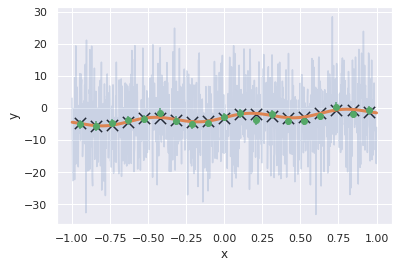

In [2]:
from scipy.stats import binned_statistic

num_bins = 20

def model(x,a,b,c):
    return np.sin(a*x) + b*x +c


true_a = 10
true_b = 2
true_c = -3

def generate_data():
    Npoints = 1000
    x = np.linspace(-1,1,Npoints)
    return model(x,true_a,true_b,true_c) + np.random.normal(scale=10,size=Npoints)
    
xs = np.linspace(-1,1,1000)
bin_edges = np.linspace(-1,1,num_bins)
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.

true_model_fine = model(xs,true_a,true_b,true_c)
binned_true = binned_statistic(xs,true_model_fine,bins=bin_edges,statistic=np.mean)[0]

data = generate_data()
binned_data = binned_statistic(xs,data,bins=bin_edges,statistic=np.mean)[0]
binned_var = binned_statistic(xs,data,bins=bin_edges,statistic=np.var)[0]
binned_count = binned_statistic(xs,data,bins=bin_edges,statistic=np.size)[0]
binned_sigma = np.sqrt(binned_var/binned_count)

xs = np.linspace(-1,1,1000)
plt.plot(xs,data,alpha=0.2,color="C0")
plt.plot(xs,true_model_fine,color="C1",lw=3)
plt.scatter(bin_centers,binned_true,marker="x",s=128,color='k')
plt.errorbar(bin_centers,binned_data,yerr=binned_sigma,marker="o",color="C2",ls="none")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Define a likelihood

In [9]:

y = binned_data
yerr = binned_sigma
def lnlike(a,b,c):
    theory = binned_statistic(xs,model(xs,a,b,c),bins=bin_edges,statistic=np.mean)[0]
    residual = y-theory
    inv_sigma2 = 1.0/(yerr**2.)
    return -0.5*(np.sum((y-theory)**2*inv_sigma2))



## Set up cobaya's dict and add priors, then run

In [18]:
info = {
    "likelihood": {
        "external": lnlike},
    "params": dict([
        ("a", {
            "prior": {"min": 5, "max": 15},
            "latex": r"\alpha"}),
        ("b", {
            "prior": {"min": 0, "max": 5},
            "latex": r"\beta"}),
        ("c", {
            "prior": {"min": -5, "max": 0},
            "latex": r"\gamma"}) ] ),
        
    "sampler": {
        "mcmc": {'max_tries':10000}}, }

from cobaya.run import run

updated_info, sampler = run(info)

[external] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {external: 417.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: a:8.138765, b:0.6739361, c:-1.31884
[mcmc] Sampling!
[mcmc] Progress @ 2020-08-14 17:20:08 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.078
[mcmc]  - Convergence of means: R-1 = 0.497463 after 120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence t

## Plot with getdist

[root] *WARNING* outlier fraction 0.010227272727272727 
Mean:
[ 9.79687086  1.66134935 -3.23959877 11.27579347 11.27579347]
Covariance matrix:
[[ 0.68205627  0.04949256  0.00084162]
 [ 0.04949256  0.30300369 -0.00805595]
 [ 0.00084162 -0.00805595  0.09519746]]


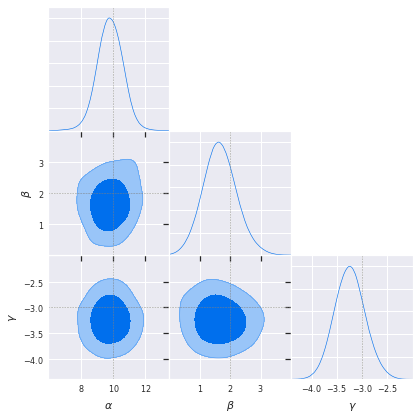

In [19]:
# Export the results to GetDist
from getdist.mcsamples import MCSamplesFromCobaya

gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])
# Analyze and plot
mean = gd_sample.getMeans()
covmat = gd_sample.getCovMat().matrix
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)
# %matplotlib inline  # uncomment if running from the Jupyter notebook
import getdist.plots as gdplt

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["a", "b","c"], filled=True,markers={"a":true_a, "b":true_b,"c":true_c})

##  MPI

MPI parallelization is easy. Simply specify an `output` directory in the dictionary so that the chains will be written to disk. Then call the script with the cobaya run command in it with mpirun (or whatever MPI wrapper you use) and the number of chains will equal the number of MPI processes. Then load the chains using getdist and plot them.